# 作业第五周（2）CNN网络练习

1.仿照课件关于deepdream的程序，在data目录选择一张背景图片(zju1.jpg或zju2.jpg或zju3.jpg或zju4.jpg或者用代码下载一张网络图片保存在save/目录)，
选取一个ImageNet预训练网络，通过选择以及组合不同的特征层，训练出一张自己满意的deepdream图片。<BR>



In [1]:
#首先执行GPU资源分配代码，勿删除。
import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(    physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

#### 定义相关函数

In [2]:
from IPython import display
import PIL.Image
import numpy as np
from tensorflow import keras
from keras.preprocessing import image

# normalize
def normalize_image(img):
    img = 255 * (img+1.0) / 2.0
    return tf.cast(img, tf.uint8)

# visualize
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))
    
# save image
def save_image(img, file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

#### 导入图片

In [3]:
def read_image(file_name,max_dim=None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-syzodn6i because the default path (/home/student/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


True


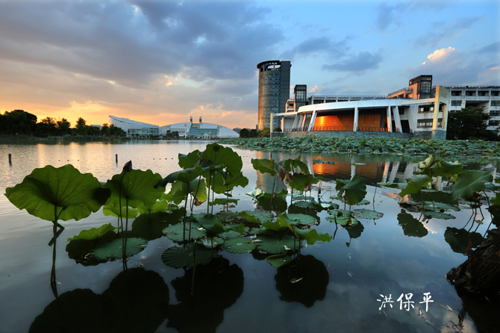

In [4]:
import os
from matplotlib import pyplot as plt
%matplotlib inline

img_path = "./data/zju1.jpg"
print(os.path.isfile(img_path))
ori_img = read_image(img_path, 500)
show_image(ori_img)

# noise image
noise_img = np.random.uniform(-1, 1, size=(300, 300, 3)) + 100
# blank image
blank_img = np.zeros(shape=(300, 300, 3)) + 100

#### 加载预训练模型

In [5]:
base_model = keras.applications.InceptionV3(include_top=False, weights="imagenet")
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
layer_names = "conv2d_30"
layers = base_model.get_layer(layer_names).output
layers

<tf.Tensor 'conv2d_30/Conv2D:0' shape=(None, None, None, 192) dtype=float32>

#### 创建特征提取模型

In [16]:
dream_model = keras.Model(inputs=base_model.input, outputs=layers)
dream_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

#### 定义损失函数

In [17]:
def calc_loss(img, model):
    channel = 13
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    act = layer_activations[:, :, :, channel]
    loss = tf.math.reduce_mean(act)
    return loss

#### 图像进化过程

In [18]:
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
        #对1mg进行佛度变换
            tape.watch(img)
            loss = calc_loss(img, model)
        
        #计算损失相对于榆入图像像素的梯度
        gradients = tape.gradient(loss,img)

        #归一化梯度值
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        #在梯度上升中，损失值越来越大，因此可以直接添加损失值到图像中，因为它们的shap相同
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

        #输出过程提示信息
        if (verbose ==1):
            if((n+1) % 10 == 0):
                print ("Step {}/{}, loss {}".format(n+1, steps, loss))
    return img

Step 10/200, loss 5.42543363571167
Step 20/200, loss 7.614504337310791
Step 30/200, loss 8.951312065124512
Step 40/200, loss 9.892330169677734
Step 50/200, loss 10.613274574279785
Step 60/200, loss 11.198891639709473
Step 70/200, loss 11.70751953125
Step 80/200, loss 12.146108627319336
Step 90/200, loss 12.522820472717285
Step 100/200, loss 12.868203163146973
Step 110/200, loss 13.181410789489746
Step 120/200, loss 13.452589988708496
Step 130/200, loss 13.712869644165039
Step 140/200, loss 13.944234848022461
Step 150/200, loss 14.163322448730469
Step 160/200, loss 14.375423431396484
Step 170/200, loss 14.568658828735352
Step 180/200, loss 14.760143280029297
Step 190/200, loss 14.944046974182129
Step 200/200, loss 15.12226676940918
total time: 7.944331169128418


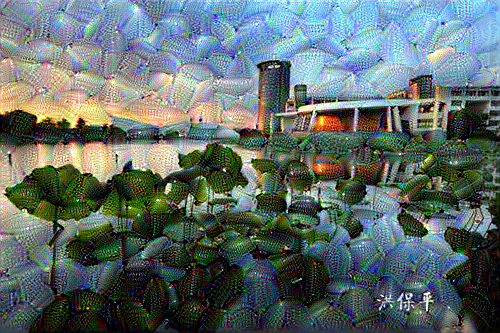

In [19]:
import time

img = keras.applications.inception_v3.preprocess_input(ori_img)
img = tf.convert_to_tensor(img) 

start = time.time()
dream_img = render_deepdream(dream_model, img, steps=200, step_size=0.01)
end = time.time()
print(f"total time: {end-start}")

dream_img = normalize_image(dream_img)
show_image(dream_img)

#### 多通道

In [20]:
def calc_loss(img, model):
    channels = [13, 109]
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    
    losses = []
    for ch in channels:
        act = layer_activations[:, :, :, ch]
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)

Step 10/200, loss 8.401939392089844
Step 20/200, loss 11.344013214111328
Step 30/200, loss 13.117944717407227
Step 40/200, loss 14.402848243713379
Step 50/200, loss 15.405678749084473
Step 60/200, loss 16.249923706054688
Step 70/200, loss 16.937755584716797
Step 80/200, loss 17.552133560180664
Step 90/200, loss 18.089872360229492
Step 100/200, loss 18.573060989379883
Step 110/200, loss 19.019237518310547
Step 120/200, loss 19.43240737915039
Step 130/200, loss 19.808433532714844
Step 140/200, loss 20.174287796020508
Step 150/200, loss 20.517520904541016
Step 160/200, loss 20.83466339111328
Step 170/200, loss 21.143753051757812
Step 180/200, loss 21.427732467651367
Step 190/200, loss 21.704256057739258
Step 200/200, loss 21.964601516723633
total time: 8.176156520843506


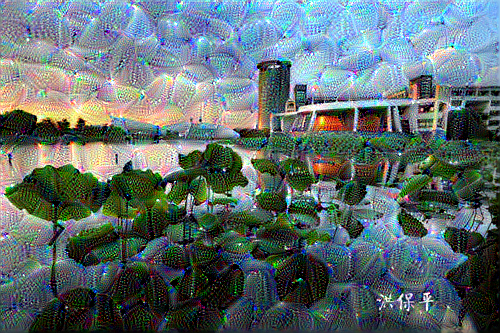

In [21]:
import time

img = keras.applications.inception_v3.preprocess_input(ori_img)
img = tf.convert_to_tensor(img) 

start = time.time()
dream_img = render_deepdream(dream_model, img, steps=200, step_size=0.01)
end = time.time()
print(f"total time: {end-start}")

dream_img = normalize_image(dream_img)
show_image(dream_img)

#### 多层且全部通道综合

In [22]:
layer_names = ["mixed3", "mixed5"]
layers = [base_model.get_layer(name).output for name in layer_names]
dream_model = keras.Model(inputs=base_model.input, outputs=layers)

In [23]:
def calc_loss(img, model):
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)
    

Step 10/200, loss 1.2320091724395752
Step 20/200, loss 1.5013737678527832
Step 30/200, loss 1.6662304401397705
Step 40/200, loss 1.7891463041305542
Step 50/200, loss 1.8895788192749023
Step 60/200, loss 1.97019362449646
Step 70/200, loss 2.0417304039001465
Step 80/200, loss 2.105302095413208
Step 90/200, loss 2.1602859497070312
Step 100/200, loss 2.2122461795806885
Step 110/200, loss 2.258854627609253
Step 120/200, loss 2.3029861450195312
Step 130/200, loss 2.343967914581299
Step 140/200, loss 2.3824477195739746
Step 150/200, loss 2.4202229976654053
Step 160/200, loss 2.4552884101867676
Step 170/200, loss 2.4892921447753906
Step 180/200, loss 2.5225794315338135
Step 190/200, loss 2.5545449256896973
Step 200/200, loss 2.5858514308929443
total time: 13.150635719299316


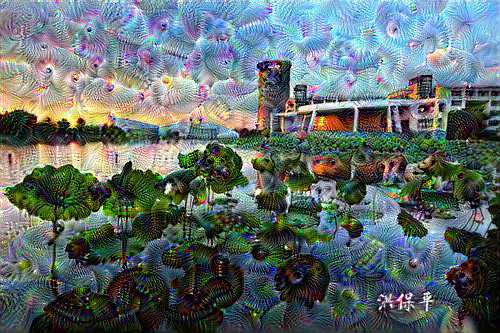

In [24]:
import time

img = keras.applications.inception_v3.preprocess_input(ori_img)
img = tf.convert_to_tensor(img) 

start = time.time()
dream_img = render_deepdream(dream_model, img, steps=200, step_size=0.01)
end = time.time()
print(f"total time: {end-start}")

dream_img = normalize_image(dream_img)
show_image(dream_img)

#### 效果优化

Step 10/50, loss 1.1585365533828735
Step 20/50, loss 1.3966177701950073
Step 30/50, loss 1.5526108741760254
Step 40/50, loss 1.6677632331848145
Step 50/50, loss 1.758690595626831
Step 10/50, loss 1.3850427865982056
Step 20/50, loss 1.5662243366241455
Step 30/50, loss 1.6864278316497803
Step 40/50, loss 1.7750017642974854
Step 50/50, loss 1.8460135459899902
Step 10/50, loss 1.3677560091018677
Step 20/50, loss 1.5488420724868774
Step 30/50, loss 1.6649304628372192
Step 40/50, loss 1.7522680759429932
Step 50/50, loss 1.8231834173202515
Step 10/50, loss 1.374769926071167
Step 20/50, loss 1.5564112663269043
Step 30/50, loss 1.6724623441696167
Step 40/50, loss 1.758715033531189
Step 50/50, loss 1.8285531997680664
Step 10/50, loss 1.3685798645019531
Step 20/50, loss 1.5487780570983887
Step 30/50, loss 1.663563847541809
Step 40/50, loss 1.749556064605713
Step 50/50, loss 1.8185338973999023
total time:17.187021493911743


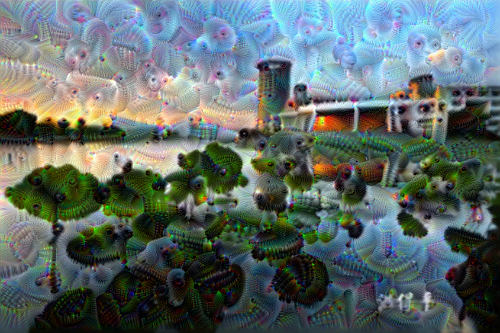

In [25]:
import time
start = time.time()
OCTAVE_SCALE = 1.30

img = keras.applications.inception_v3.preprocess_input(ori_img)
img = tf.convert_to_tensor(img) 

base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast (float_base_shape * (OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape)
    img= render_deepdream(dream_model, img, steps=50, step_size=0.005)
    
end = time.time()
print(f"total time:{end-start}")

img = tf.image.resize(img, base_shape)
dream_img = normalize_image(img)
show_image(dream_img)